# Moving Averages CINGULATE region

This corresponds to the visualization on the first HCP half of the t-SNE and clustering of the two models (first model being run on the first half, the second model being run on the second half of HCP)

# 1) Imports

In [1]:
import os
import glob
import sys
import json
import shutil

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)

In [2]:
import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

import torch

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.manifold import TSNE

import matplotlib.cm as cm

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig

In [3]:
# If true, saves meshes as files
save_mesh = False

# If true, saves buckets as files
save_bucket = False

# 2) Functions and datasets

In [4]:
def closest_distance(centroid, df):
    """Returns closest point to centroid of a given cluster
    /!\ central_point is part of the defined set of points
    Args:
        IN: centroid: tuple of coordinates of centroid
            df: pandas.DataFrame with index corresponding to subjects and as many columns as coordinates
        OUT: central_point: subject ID corresponding to closest point to the centroid
    """
    # df must have as many columns as dimensions to consider
    distances = {}
    # Get distances to centroid for each point
    for sub in list(df.index):
        pos = [df.loc[sub][k] for k in range(0, len(df.columns))]
        distances[sub] = distance.euclidean(pos, centroid)
    # Get closest point to centroid
    central_point = min(distances, key=distances.get)
    return central_point

In [5]:
def mscatter(x, y, ax=None, m=None, **kw):
    if not ax:
        ax = plt.gca()
    sc = ax.scatter(x, y, **kw)
    if (m is not None) and (len(m) == len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [6]:
path = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/centered_combined/hcp/Rcrops/'

In [7]:
run_dir = '/host/volatile/jc225751/Runs/29_MIDL_2022_clean'

In [8]:
if torch.cuda.is_available():
    device = "cuda:0"
print(device)

cuda:0


In [9]:
# We load the embeddings
result_dir = f"{run_dir}/Output/t-0.1/n-004_o-4"
train_val_embeddings_file = f"{result_dir}/train_val_embeddings.pt"
embeddings = torch.load(train_val_embeddings_file)
print(embeddings.shape)

torch.Size([550, 4])


In [10]:
# We load the embeddings from the second half
result_dir2 = f"{run_dir}/Output/t-0.1/n-004_o-4_2nde_half"
train_val_embeddings_file2 = f"{result_dir2}/train_val_embeddings.pt"
embeddings2 = torch.load(train_val_embeddings_file2)
print(embeddings2.shape)

torch.Size([550, 4])


In [11]:
# We load the labels
with open(f"{result_dir}/train_val_filenames.json", 'r') as f:
    subject_labels = json.load(f)
print(subject_labels[0])    

129634


# 3) T-SNE and different clusterings

In [12]:
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=50)
X_tsne = tsne.fit_transform(embeddings)

In [13]:
tsne2 = TSNE(n_components=2, perplexity=25, init='pca', random_state=50)
X_tsne2 = tsne2.fit_transform(embeddings2)

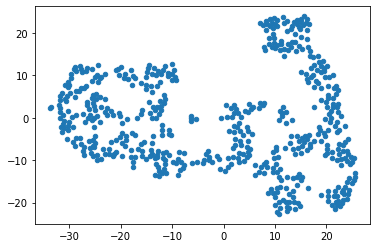

In [14]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], s=20, ax=ax)
plt.show()


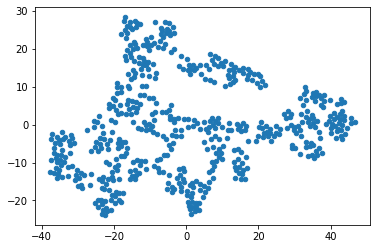

In [15]:
fig, ax = plt.subplots(1)
mscatter(X_tsne2[:, 0], X_tsne2[:, 1], s=20, ax=ax)
plt.show()

In [16]:
X_tsne.shape 

(550, 2)

In [17]:
X_tsne2.shape 

(550, 2)

In [18]:
def clustering_af(points_TSNE):
    af = AffinityPropagation().fit(points_TSNE)
    cluster_labels_af = af.labels_
    x_cluster_label_af = af.predict(points_TSNE)
    initial_centers = af.cluster_centers_indices_
    n_clusters_ = len(initial_centers)
    while n_clusters_ > 5:
        af = AffinityPropagation().fit(points_TSNE[af.cluster_centers_indices_])
        cluster_labels_af = af.labels_
        x_cluster_label_af = af.predict(points_TSNE)
        n_clusters_ = len(af.cluster_centers_indices_)
        print(n_clusters_)
    clusters_centers_af = af.cluster_centers_

    print(f"Average silhouette score: {metrics.silhouette_score(points_TSNE, x_cluster_label_af)}")

    return x_cluster_label_af, cluster_labels_af, clusters_centers_af


In [19]:
x_cluster_label_af, cluster_labels_af, clusters_centers_af = clustering_af(X_tsne)

4
Average silhouette score: 0.4238118529319763


In [20]:
x_cluster_label_af2, cluster_labels_af2, clusters_centers_af2 = clustering_af(X_tsne2)

4
Average silhouette score: 0.44882825016975403


In [21]:
type(x_cluster_label_af)

numpy.ndarray

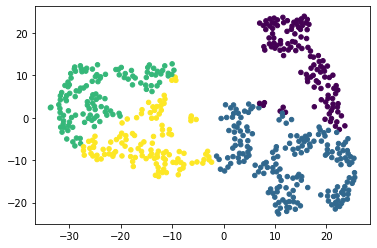

In [22]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_af, s=20, ax=ax)
plt.show()

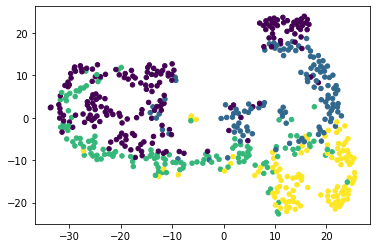

In [23]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_af2, s=20, ax=ax)
plt.show()

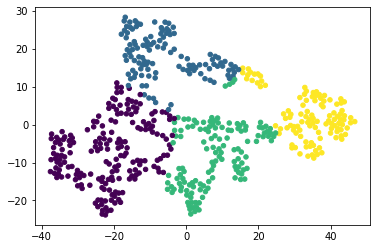

In [24]:
fig, ax = plt.subplots(1)
mscatter(X_tsne2[:, 0], X_tsne2[:, 1], c=x_cluster_label_af2, s=20, ax=ax)
plt.show()

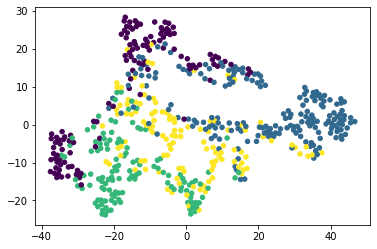

In [25]:
fig, ax = plt.subplots(1)
mscatter(X_tsne2[:, 0], X_tsne2[:, 1], c=x_cluster_label_af, s=20, ax=ax)
plt.show()

In [26]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_tsne)
cluster_labels_kmeans = kmeans.labels_
x_cluster_label_kmeans = kmeans.predict(X_tsne)
clusters_centroids_kmeans = kmeans.cluster_centers_
print(f"clusters centroids = {clusters_centroids_kmeans.shape}")
print(f"Average silhouette score: {metrics.silhouette_score(X_tsne, cluster_labels_kmeans)}")


clusters centroids = (10, 2)
Average silhouette score: 0.4572193920612335


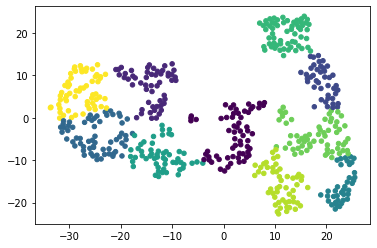

In [27]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_kmeans, s=20, ax=ax)
plt.show()

In [28]:
dbscan = DBSCAN(eps=2).fit(X_tsne)
cluster_labels_dbscan = dbscan.labels_
x_cluster_label_dbscan = dbscan.fit_predict(X_tsne)
print(f"Average silhouette score: {metrics.silhouette_score(X_tsne, cluster_labels_dbscan)}")


Average silhouette score: 0.01872294768691063


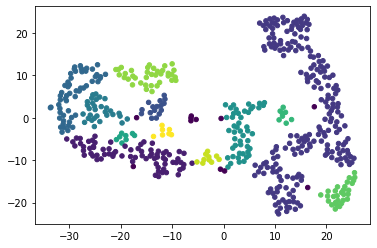

In [29]:
fig, ax = plt.subplots(1)
mscatter(X_tsne[:, 0], X_tsne[:, 1], c=x_cluster_label_dbscan, s=20, ax=ax)
plt.show()

# 4) Compare SimCLR and betaVAE

In [30]:
x_cluster_label_af.shape

(550,)

In [31]:
dstrb_sub = pd.DataFrame(X_tsne, index=subject_labels, columns=[0,1])
dstrb_sub['af_label'] = x_cluster_label_af

In [32]:
dstrb_sub.head()

,0,1,af_label
129634,-25.234621,-6.989079,3
136833,-19.723698,-9.008698,3
206222,22.822351,-11.067300,1
138837,20.976093,-0.183199,0
987983,18.855858,10.753638,0


In [33]:
clusters_centroids = clusters_centers_af
print(f"cluster's centroids coordinates: \n {clusters_centroids}")

cluster's centroids coordinates: 
 [[ 18.855858   10.753638 ]
 [ 10.188089  -10.928673 ]
 [-27.188335    6.992881 ]
 [-14.090506   -7.6115336]]


In [34]:
dstrb_sub.loc[dstrb_sub.index[0]]

0          -25.234621
1           -6.989079
af_label     3.000000
Name: 129634, dtype: float64

In [35]:
central_af = []
for i in range(clusters_centroids.shape[0]):
    central_af.append(closest_distance(clusters_centroids[i], dstrb_sub.drop(['af_label'], axis=1)))
    print(f"Closest subject to centroid of cluster {i} is {central_af[i]}")

Closest subject to centroid of cluster 0 is 987983
Closest subject to centroid of cluster 1 is 137633
Closest subject to centroid of cluster 2 is 146836
Closest subject to centroid of cluster 3 is 105216


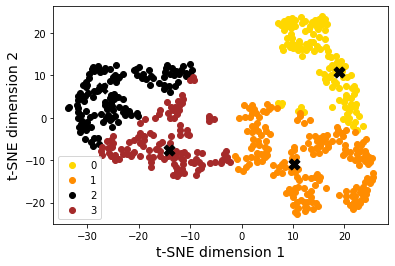

In [72]:
arr = np.array([np.array([dstrb_sub[k][i] for k in dstrb_sub.columns[0:2]]) for i in range(len(dstrb_sub))])

color_dict = {0: 'gold', 1:'darkorange', 2:'black', 3:'brown'}
fig, ax = plt.subplots()

for g in np.unique([dstrb_sub.af_label]):
    ix = np.where(dstrb_sub.af_label == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g], label = g)

for g in np.unique([dstrb_sub.af_label]):
    ax.scatter(clusters_centroids[g][0],
               clusters_centroids[g][1],
               color='black',
               marker='X',
               s=120)

plt.xlabel(f't-SNE dimension 1', fontsize=14)
plt.ylabel(f't-SNE dimension 2', fontsize=14)
plt.legend()
plt.show()

In [42]:
betavae = pd.read_csv('label_bvae.csv')

In [43]:
betavae.head()

,Unnamed: 0,1,2,cluster_lab
0,131924,-19.186666,5.052786,3
1,692964,17.274990,12.390187,2
2,159946,-23.090307,0.775272,3
3,122822,13.033621,31.161682,0
4,352132,8.874580,-42.764572,1


In [46]:
betavae = betavae.rename(columns={"Unnamed: 0":"subjects"})

In [49]:
betavae.subjects = betavae.subjects.astype('str')

In [37]:
dstrb_sub.head()

,0,1,af_label
129634,-25.234621,-6.989079,3
136833,-19.723698,-9.008698,3
206222,22.822351,-11.067300,1
138837,20.976093,-0.183199,0
987983,18.855858,10.753638,0


In [ ]:
m2 = pd.merge(dstrb_sub, betavae, left_on=dstrb_sub.index, right_on=betavae.subjects)

In [53]:
m2 = m2.rename(columns={"cluster_lab": "betavae_lab"})

In [54]:
m2 = m2.rename(columns={"af_label": "simclr_lab"})

In [55]:
m2.head()

,key_0,0,1,simclr_lab,subjects,1,2,betavae_lab
0,129634,-25.234621,-6.989079,3,129634,13.234862,-39.168453,1
1,136833,-19.723698,-9.008698,3,136833,14.744742,-13.902143,2
2,206222,22.822351,-11.067300,1,206222,-9.973412,-6.130984,3
3,138837,20.976093,-0.183199,0,138837,-23.123827,5.394363,3
4,987983,18.855858,10.753638,0,987983,-1.782911,34.792870,0


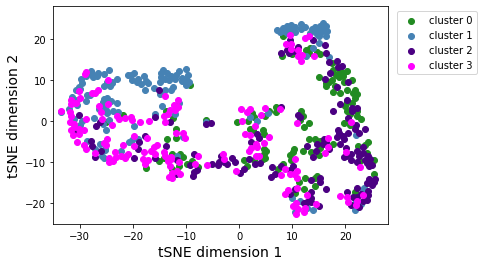

In [63]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m2.betavae_lab]):
    ix = np.where(m2.betavae_lab == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g], label = f"cluster {g}")

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.28,1))
plt.xlim(-35,28)
plt.ylim(-25,28)
plt.show()

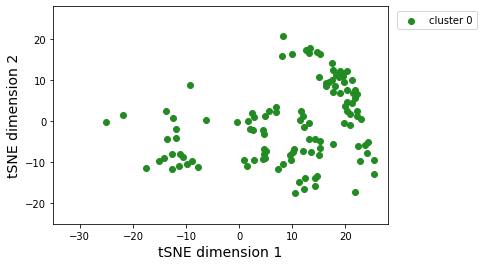

In [64]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m2.betavae_lab]):
    if g == 0:
        ix = np.where(m2.betavae_lab == g)
        x = [arr[ix][k][0] for k in range(len(ix[0]))]
        y = [arr[ix][k][1] for k in range(len(ix[0]))]
        ax.scatter(x, y, c = color_dict[g], label = f"cluster {g}")

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.28,1))
plt.xlim(-35,28)
plt.ylim(-25,28)
plt.show()

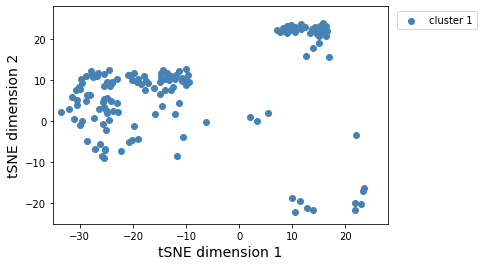

In [65]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m2.betavae_lab]):
    if g == 1:
        ix = np.where(m2.betavae_lab == g)
        x = [arr[ix][k][0] for k in range(len(ix[0]))]
        y = [arr[ix][k][1] for k in range(len(ix[0]))]
        ax.scatter(x, y, c = color_dict[g], label = f"cluster {g}")

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.28,1))
plt.xlim(-35,28)
plt.ylim(-25,28)
plt.show()

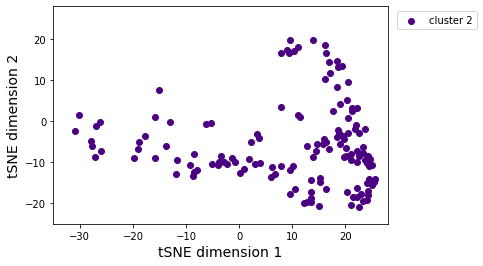

In [66]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m2.betavae_lab]):
    if g == 2:
        ix = np.where(m2.betavae_lab == g)
        x = [arr[ix][k][0] for k in range(len(ix[0]))]
        y = [arr[ix][k][1] for k in range(len(ix[0]))]
        ax.scatter(x, y, c = color_dict[g], label = f"cluster {g}")

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.28,1))
plt.xlim(-35,28)
plt.ylim(-25,28)
plt.show()

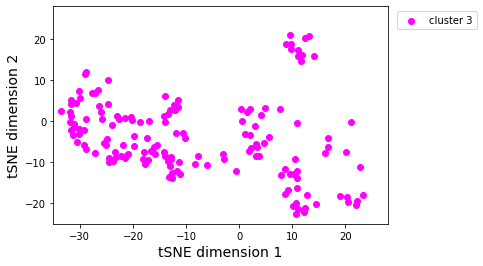

In [67]:
arr = np.array([np.array([m2[k][i] for k in m2.columns[1:3]]) for i in range(len(m2))])

color_dict = {0:'forestgreen',1: 'steelblue', 2:'indigo', 3:'magenta'}
fig, ax = plt.subplots()

for g in np.unique([m2.betavae_lab]):
    if g == 3:
        ix = np.where(m2.betavae_lab == g)
        x = [arr[ix][k][0] for k in range(len(ix[0]))]
        y = [arr[ix][k][1] for k in range(len(ix[0]))]
        ax.scatter(x, y, c = color_dict[g], label = f"cluster {g}")

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.legend(bbox_to_anchor=(1.28,1))
plt.xlim(-35,28)
plt.ylim(-25,28)
plt.show()

In [39]:
simclr_labels = dstrb_sub[['af_label']]

In [40]:
simclr_labels.to_csv('simclr_labels.csv')